# Style Transfer
- Style Transfer란?
- 구현


### Style Transfer이란?
- 딥러닝과 컴퓨터 비전 기술 중 한 분야로 주어진 두개의 이미지를 이용하여 새로운 이미지를 생성하는 기술이다. 각각의 이미지를 "콘텐츠 이미지"와 "스타일 이미지"로 지정하여 스타일 이미지의 특징들을 콘텐츠 이미지에 적용하는 기법이다.
- 주어진 콘텐츠 이미지의 내용은 보존하면서, 스타일 이미지의 텍스처, 색상, 그라디언트 등의 스타일을 전달해야하므로 콘텐츠 이미지의 내용 손실을 최소화하고, 동시에 스타일 이미지의 특징을 최대한 반영할수있도록 하는것이 기술의 핵심이다.


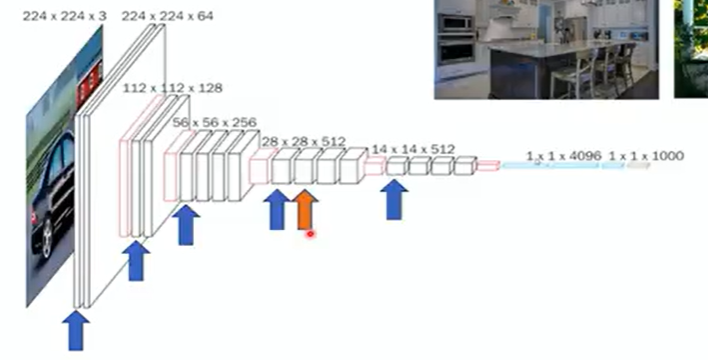

- 위 신경망 이미지는 Style Transfer에 사용될 합성곱 신경망이다. 각각의 특징을 살펴보자
  1. 흰색 층은 conv층, 빨간색은 maxpooling층 이다.
  2. 주황색 화살표는 파란색 화살표는 스타일 이미지에서 추출한 특징들을 가지고있는 층들이다.
    - 5개의 스타일 층
    - 1개의 콘텐츠 층

Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

In [2]:
# 위에 사진에 표시된 파란색 conv층과 빨간색 conv층의 아웃풋을 활용하여 스타일 전이를 구현한다.
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
network.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [16]:
len(network.layers)

22

### Loading and preprocessing the images
- 스타일 이미지와 콘탠츠 이미지를 따로 불러온다.

#### Content image

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# 굳이 target_size를 설정하지 않는 이유는 원본이미지가 신경망 모델에 적합한 사이즈기 때문이다.
content_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/chaves.jpeg')

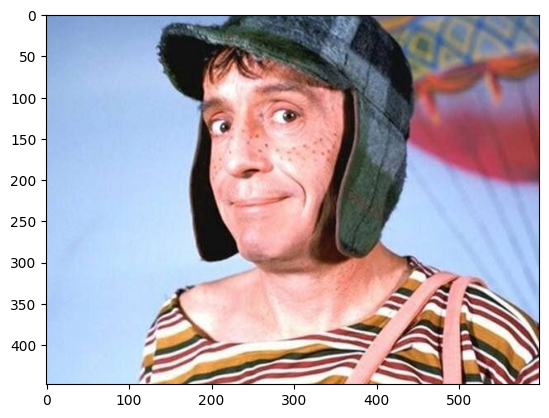

In [34]:
plt.imshow(content_image);

In [35]:
type(content_image)# PIL타입의 이미지라 형식을 바꿔줘야한다.

PIL.JpegImagePlugin.JpegImageFile

In [36]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [37]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (448, 598, 3), 0.0, 255.0)

In [38]:
content_image = content_image / 255 # 0~1로 변환

In [39]:
# 현재 (세로, 가로, 채널) 순이지만 모델에 전송하기위해선 (이미지 개수, 세로, 가로, 채널)로 변경해줘야한다
content_image.shape

(448, 598, 3)

In [40]:
# 데이터 차원 축소 및 추가 방법 : https://han-py.tistory.com/341
# 차원을 추가하기위한 새로운 방법 tf.newaxis
content_image = content_image[tf.newaxis, :]

In [41]:
content_image.shape

(1, 448, 598, 3)

#### Style image

In [44]:
style_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/tarsila_amaral.jpg')

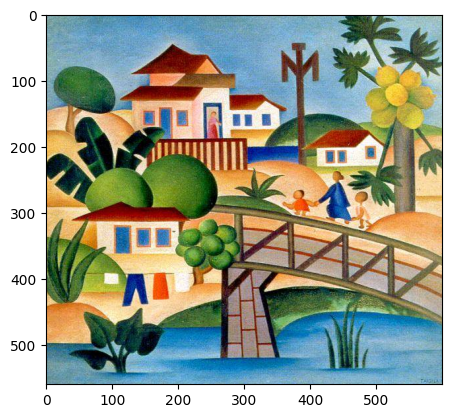

In [45]:
plt.imshow(style_image);

In [46]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

### Building the neural network
- Content_layers : 콘텐츠 이미지의 내용을 보존하기 위해 선택된 레이어이다. 이 레이어는 고수준 특징(객체의 형태나 위치)를 포착하는 경향이 있는 레이어이다.

- Style_layers: 스타일 이미지의 스타일을 정의하기 위해 선택된 레이어이다. 콘텐츠 레이어와 다르게 저수준의 특징(색상이나 질감)을 포착하는 경향이 있다.


  \* 각각의 레이어층의 모델의 특징들은 VGG 모델에 대한 특징을 발견하여 정립한것이다.(일반적으로도 conv층이 여러번 수행될때마다 고수준의 특징을 포착하기도 한다.)



In [6]:
# 사전에 정의했던 사용할 층을 지정
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']

In [7]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
# shape에 None인 이유가 인풋사이즈에 따라 해당층의 shape(특징맵 크기)가 달라지기때문이다 -> 인풋사이즈도 다양하게 허용한다(VGG특징)
[network.get_layer(name).output for name in style_layers] # 해당층의 활성화 값을 가져온다

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [11]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [12]:
def vgg_layers(layer_names): # 사용할 층의 활성화 값을 가져오는
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')# 변수 재정의(network변수는 사용하지 않는다)
  vgg.trainable = False # 학습과정에서 가중치가 학습되는것을 방지 -> 로드된 가중치만을 사용(이미지넷 데이터 셋)

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network


In [13]:
style_extractor = vgg_layers(style_layers)

In [15]:
style_extractor.output

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
style_outputs = style_extractor(style_image)

In [ ]:
len(style_outputs)